# Library for the Satellite images

> Indented block



## Bands
ToDo: Single band <- 7 bands,



In [2]:
!pip install earthpy

     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 19.3 MB 2.4 MB/s 
     |████████████████████████████████| 1.0 MB 14.6 MB/s 
     |████████████████████████████████| 15.4 MB 110 kB/s 
     |████████████████████████████████| 6.3 MB 32.8 MB/s 


In [3]:
pip install pyrsgis==0.3.9

## Data Prepration and pre-processing

In [5]:
import numpy as np
import random
# import sklearn
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray

# Defining file names
featureFile = 'Playa_Image.tif'
# labelFile = 'Playa_Image_Training.tif'

# Reading and normalizing input data
dsFeatures, arrFeatures = raster.read(featureFile, bands='all')
arrFeatures = arrFeatures.astype(float)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i][:][:].min()
    bandMax = arrFeatures[i][:][:].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures[i][j][k] = (arrFeatures[i][j][k]-bandMin)/bandRange

# Creating chips using pyrsgis
features = imageChipsFromArray(arrFeatures, x_size=7, y_size=7)

In [6]:
import matplotlib.pyplot as plt
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray, imageChipsFromFile
import torch.nn as nn
import torch
# Defining the function to split features and labels
def train_test_split(features,  trainProp=0.75):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    # train_y = labels[randIndex[:sliceIndex]]
    # test_y = labels[randIndex[sliceIndex:]]
    return(train_x,  test_x, )

# Calling the function to split the data
train_x, test_x = train_test_split(features)

## Dataloader

In [7]:
data_loader = torch.utils.data.DataLoader(train_x,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)


In [8]:
# mnist_data = MNIST(root='./', download=True, transform=transforms.ToTensor())
import matplotlib.pyplot as plt
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray, imageChipsFromFile
import torch.nn as nn
import torch

# read the TIF file(s) (both are of different sizes - for demonstration)
single_band_file = r'Playa_Image.tif' # this is a Landsat 5 TM image (7 bands stacked)
# multi_band_file = r'Playa_Image.tif' # this is a Landsat 5 TM image (7 bands stacked)

# create image chips
single_band_chips = imageChipsFromFile(single_band_file, x_size=28, y_size=28)
# multi_band_chips = imageChipsFromFile(multi_band_file, x_size=16, y_size=16)

print(single_band_chips.shape)
# print(multi_band_chips.shape)
print(single_band_chips[1].shape)

(189658, 28, 28, 7)
(28, 28, 7)


In [9]:
print(len(single_band_chips))

189658


## Change datatype

In [10]:
import numpy as np
import cv2 
import tensorflow as tf


# changin the type of data images 
single_band_chips        = np.rollaxis(single_band_chips, 3, 1)
single_band_chips_float  = single_band_chips.astype(np.float32)

single_band_chips_tensor = torch.as_tensor(single_band_chips_float)

print(single_band_chips_tensor.dtype)

print('no of chips: bends: h: W ',single_band_chips.shape)

torch.float32
no of chips: bends: h: W  (189658, 7, 28, 28)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from utils import ACTIVATION_DERIVATIVES
import math
import torch
# from flows import RadialFlow, PlanarFlow
from tqdm import tqdm
import torch.nn.functional as F
# from models import FCNEncoder, FCNDecoder, FlowModel
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from matplotlib import pyplot as plt
from scipy.special import logsumexp
import numpy as np
from sklearn.datasets import make_moons
from matplotlib import collections  as mc

## VAE Flow model

In [12]:
from typing import List
class FCNEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        
        hidden_sizes = [dim_input] + hidden_sizes
        
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

        
    def forward(self, x):
        return self.net(x)

In [13]:
from torch.distributions.multivariate_normal import MultivariateNormal

class FlowModel(nn.Module):
    def __init__(self, flows: List[str], D: int, activation=torch.tanh):
        super().__init__()
        
        self.prior = MultivariateNormal(torch.zeros(D), torch.eye(D))
        self.net = []

        for i in range(len(flows)):
            layer_class = eval(flows[i])
            self.net.append(layer_class(D, activation))

        self.net = nn.Sequential(*self.net)

        self.D = D


    def forward(self, mu: torch.Tensor, log_sigma: torch.Tensor):
        """
        mu: tensor with shape (batch_size, D)
        sigma: tensor with shape (batch_size, D)
        """
        sigma = torch.exp(log_sigma)
        batch_size = mu.shape[0]
        samples = self.prior.sample(torch.Size([batch_size]))
        # print(samples.size, sigma.shape)
        z = samples * sigma + mu

        z0 = z.clone().detach()
        log_prob_z0 = torch.sum(
            -0.5 * torch.log(torch.tensor(2 * math.pi)) - 
            log_sigma - 0.5 * ((z - mu) / sigma) ** 2, 
            axis=1)
        
        log_det = torch.zeros((batch_size,))
        
        for layer in self.net:
            z, ld = layer(z)
            log_det += ld

        log_prob_zk = torch.sum(
            -0.5 * (torch.log(torch.tensor(2 * math.pi)) + z ** 2), 
            axis=1)

        return z, log_prob_z0, log_prob_zk, log_det

In [14]:
ACTIVATION_DERIVATIVES = {
    F.elu: lambda x: torch.ones_like(x) * (x >= 0) + torch.exp(x) * (x < 0),
    torch.tanh: lambda x: 1 - torch.tanh(x) ** 2
}

class PlanarFlow(nn.Module):
    def __init__(self, D, activation=torch.tanh):
        super().__init__()
        self.D = D
        self.w = nn.Parameter(torch.empty(D))
        self.b = nn.Parameter(torch.empty(1))
        self.u = nn.Parameter(torch.empty(D))
        self.activation = activation
        self.activation_derivative = ACTIVATION_DERIVATIVES[activation]

        nn.init.normal_(self.w)
        nn.init.normal_(self.u)
        nn.init.normal_(self.b)

    def forward(self, z: torch.Tensor):
        lin = (z @ self.w + self.b).unsqueeze(1)  # shape: (B, 1)
        f = z + self.u * self.activation(lin)  # shape: (B, D)
        phi = self.activation_derivative(lin) * self.w  # shape: (B, D)
        log_det = torch.log(torch.abs(1 + phi @ self.u) + 1e-4) # shape: (B,)
        

        return f, log_det


class RadialFlow(nn.Module):
    def __init__(self, D, activation=torch.tanh):
        super().__init__()

        self.z0 = nn.Parameter(torch.empty(D))
        self.log_alpha = nn.Parameter(torch.empty(1))
        self.beta = nn.Parameter(torch.empty(1))
        self.activation = activation
        self.activation_derivative = ACTIVATION_DERIVATIVES[activation]
        self.D = D

        nn.init.normal_(self.z0) 
        nn.init.normal_(self.log_alpha)
        nn.init.normal_(self.beta)


    def forward(self, z: torch.Tensor):
        z_sub = z - self.z0
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z_sub)
        h = 1 / (alpha + r)
        f = z + self.beta * h * z_sub
        log_det = (self.D - 1) * torch.log(1 + self.beta * h) + \
            torch.log(1 + self.beta * h + self.beta - self.beta * r / (alpha + r) ** 2)

        return f, log_det

In [15]:
class FCNDecoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        hidden_sizes = [dim_input] + hidden_sizes
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

    def forward(self, z: torch.Tensor):
        return self.net(z)

In [ ]:
D = 40 # Depth (No. of channels)
encoder = FCNEncoder(hidden_sizes=[128, 64, 2*D], dim_input=7*7*7)
flow_model = FlowModel(flows=['PlanarFlow'] * 10, D=40)
decoder = FCNDecoder(hidden_sizes=[64, 128, 343], dim_input=40)
# optimizer Adam
optimizer = optim.Adam(list(encoder.parameters()) + list(flow_model.parameters()) + list(decoder.parameters()))

In [39]:
def gaussian_likelihood(x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1))
def kl_divergence(z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

## Training of the model

In [58]:
loss_fn = BCEWithLogitsLoss()
running_loss = []
reconstruction_loss = []
rec_loss = []
for i, X_batch in enumerate(data_loader):
    optimizer.zero_grad()
    out = encoder(X_batch.view(-1, 7*49).float())
    mu, log_sigma = out[:, :40], out[:, 40:]
    z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
    x_hat = decoder(z_k)
    # print(x_hat.shape)
    # print(X_batch.shape)
    log_scale = nn.Parameter(torch.Tensor([0.0]))
    x = X_batch.view(-1, 343).float()
    recon_loss = gaussian_likelihood(x_hat, log_scale, x)
    recon_loss = torch.mean(recon_loss)

    # ELBO
    std = torch.exp(log_sigma / 2)
    kl = kl_divergence(z_k, mu, std)

    # elbo
    elbo = (kl - recon_loss)
    elbo = elbo.mean()

    loss = torch.mean(log_prob_z0) + loss_fn(x_hat, X_batch.view(-1, 343).float()) - torch.mean(log_prob_zk) - torch.mean(log_det)
    if i % 100 == 0:
        print(f'Iteration {i}, loss: {elbo.item()}')
        # print(f'Iteration {i}, reconstruction loss: {recon_loss.item()}')
        # running_loss.append(loss)
        reconstruction_loss.append(elbo // 1000)
        # rec_loss.append(recon_loss)
    
    # loss.backward()
    elbo.backward()
    optimizer.step()

Iteration 0, loss: -119254.25
Iteration 100, loss: -120714.0
Iteration 200, loss: -122147.0390625
Iteration 300, loss: -123594.203125
Iteration 400, loss: -125095.6796875
Iteration 500, loss: -126700.34375
Iteration 600, loss: -128233.046875
Iteration 700, loss: -129746.5234375
Iteration 800, loss: -131395.875
Iteration 900, loss: -132835.265625
Iteration 1000, loss: -134465.890625
Iteration 1100, loss: -135722.125
Iteration 1200, loss: -137544.59375
Iteration 1300, loss: -139195.703125
Iteration 1400, loss: -140574.734375
Iteration 1500, loss: -142203.4375
Iteration 1600, loss: -143814.015625
Iteration 1700, loss: -145540.15625
Iteration 1800, loss: -147001.046875
Iteration 1900, loss: -148703.015625
Iteration 2000, loss: -150230.703125
Iteration 2100, loss: -152105.546875
Iteration 2200, loss: -153626.296875
Iteration 2300, loss: -155260.875
Iteration 2400, loss: -156864.265625
Iteration 2500, loss: -158820.765625
Iteration 2600, loss: -160223.90625
Iteration 2700, loss: -161976.2187

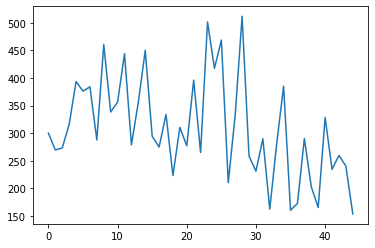

In [53]:
plt.plot(running_loss)

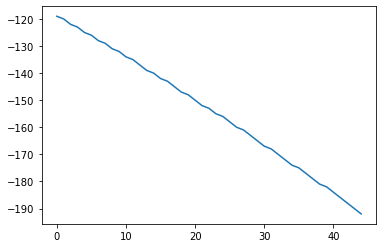

In [59]:
plt.plot(reconstruction_loss)

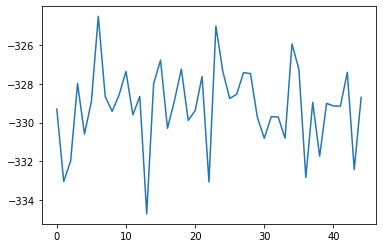

In [55]:
plt.plot(rec_loss)

In [19]:
out = encoder(X_batch.view(-1, 343).float())
mu, log_sigma = out[:, :D], out[:, D:]
z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)

x_hat = decoder(z_k)

loss = torch.mean(log_prob_z0) + loss_fn(x_hat, X_batch.view(-1, 343).float()) - torch.mean(log_prob_zk) - torch.mean(log_det)
print(loss)

tensor(5.4054, grad_fn=<SubBackward0>)


In [21]:
print(x_hat.shape)

torch.Size([23, 343])


# Reconstruction loss 

In [32]:
def gaussian_likelihood(x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1))

In [36]:
def kl_divergence(z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

In [33]:
log_scale = nn.Parameter(torch.Tensor([0.0]))
x = X_batch.view(-1, 343).float()
recon_loss = gaussian_likelihood(x_hat, log_scale, x)
print(recon_loss)

# or 

# compute the average MSE error, then scale it up i.e. simply sum on all axes
# def vae_loss(input_img, output):
#     
#     reconstruction_loss = K.sum(K.square(output-input_img))
#     # compute the KL loss
#     kl_loss = -0.5 * K.sum(1 + log_stddev - K.square(mean) - K.square(K.exp(log_stddev)), axis=-1)
#     # return the average loss over all images in batch
#     total_loss = K.mean(reconstruction_loss + kl_loss)
#     return total_loss

tensor([-377.9277, -340.8873, -342.8401, -352.6749, -354.1107, -357.5807,
        -345.2680, -340.1005, -346.5282, -347.6685, -362.1622, -350.8624,
        -343.0221, -393.4669, -360.1813, -325.8000, -349.4560, -380.3485,
        -349.4978, -340.2969, -326.9481, -335.4510, -335.0865],
       grad_fn=<SumBackward1>)


# Evidence lower bound
1.   Some things may not be obvious still from this explanation. First, each image will end up with its own q. The KL term will push all the qs towards the same p (called the prior). But if all the qs, collapse to p, then the network can cheat by just mapping everything to zero and thus the VAE will collapse
2.   The reconstruction term, forces each q to be unique and spread out so that the image can be reconstructed correctly


3. you may experience instability in training VAEs because of mu and sigma(var).



In [38]:
# distribution parameters
# fc_mu = nn.Linear(enc_out_dim, latent_dim)
# fc_var = nn.Linear(enc_out_dim, latent_dim)
# mu, log_var = fc_mu(out), fc_var(out)

# # sample z from q
# mu, log_sigma
# z = z_k.rsample()
std = torch.exp(log_sigma / 2)
# q = torch.distributions.Normal(mu, std)
# z = q.rsample()

# kl
kl = kl_divergence(z_k, mu, std)

# elbo
elbo = (kl - recon_loss)
# elbo = elbo.mean()
print(elbo)

tensor([379.0807, 340.5480, 342.8879, 354.5043, 354.1450, 358.6669, 345.6901,
        340.0118, 347.4875, 347.2278, 362.6777, 350.3609, 344.3146, 393.3160,
        360.4542, 326.0611, 348.7006, 380.4763, 350.4169, 340.5782, 328.7803,
        335.1273, 336.0437], grad_fn=<SubBackward0>)


# Trash

In [ ]:
import numpy as np
import random
# import sklearn
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray

# Defining file names
featureFile = 'Playa_Image.tif'
# labelFile = 'Playa_Image_Training.tif'

# Reading and normalizing input data
dsFeatures, arrFeatures = raster.read(featureFile, bands='all')
arrFeatures = arrFeatures.astype(float)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i][:][:].min()
    bandMax = arrFeatures[i][:][:].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures[i][j][k] = (arrFeatures[i][j][k]-bandMin)/bandRange

# Creating chips using pyrsgis
features = imageChipsFromArray(arrFeatures, x_size=7, y_size=7)

In [ ]:
print(features.shape)

(188788, 7, 7, 7)


In [ ]:
# Defining the function to split features and labels
def train_test_split(features,  trainProp=0.75):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    # train_y = labels[randIndex[:sliceIndex]]
    # test_y = labels[randIndex[sliceIndex:]]
    return(train_x,  test_x, )

# Calling the function to split the data
train_x, test_x = train_test_split(features)

In [ ]:
print(train_x.shape, test_x.shape)

(141591, 7, 7, 7) (47197, 7, 7, 7)


In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

class BinarizedMNIST(Dataset):
    def __init__(self, file):
        self.data = np.load(file)
        self.data = torch.tensor(self.data)

    def __len__(self,):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# mnist_data = MNIST(root='./', download=True, transform=transforms.ToTensor())
# data = BinarizedMNIST(single_band_chips)
data_loader = torch.utils.data.DataLoader(single_band_chips_tensor,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)

In [ ]:
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray, imageChipsFromFile
import torch.nn as nn
import torch
# read the TIF file(s) (both are of different sizes - for demonstration)
single_band_file = r'Playa_Image.tif'
multi_band_file = r'Playa_Image.tif' # this is a Landsat 7 TM image (7 bands stacked)

# create image chips
single_band_chips = imageChipsFromFile(single_band_file, x_size=16, y_size=16)
multi_band_chips  = imageChipsFromFile(multi_band_file, x_size=16, y_size=16)

print(single_band_chips.shape)
print(multi_band_chips.shape)
# # read the files as array using pyrsgis raster.read module
# _, single_band_array = raster.read(single_band_file)
# _, multi_band_array = raster.read(multi_band_file)

# # create image chips
# single_band_chips = imageChipsFromArray(single_band_array, x_size=5, y_size=5)
# multi_band_chips  = imageChipsFromArray(multi_band_array, x_size=5, y_size=5)

# print(single_band_chips.shape)
# print(multi_band_chips.shape)

Warning! matplotlib_scalebar library not found. You may not be able to export map directly.
(189658, 16, 16, 7)
(189658, 16, 16, 7)
